# The Quantum Natural Gradient

Any variational algorithm that we may come with involves optimizing a quantum state that belongs to a Hilbert space. This, in turn, means that we are not optimizing in $\mathbb{R}^N$, where the parameter vector lives. Instead, we are optimizing in a much more complex manifold that, in general, will not be flat.

In most interesting cases, and especially as the size of the Hilbert space increases, this will lead to unsatisfactory results when any gradient-based optimization is performed. Following a simple gradient-descent rule, this means that the parameters at step $t$, $\vec{\Theta}_t$, will be updated as:
$$ \vec{\Theta}_{t+1} = \vec{\Theta}_t -\eta \vec{\nabla}C\left(\vec{\Theta}_t\right)\,,$$
where $\eta$ is the so-called learning rate and $C\left(\vec{\Theta}\right)$ is the desired cost function. The reason why this optimization will usually failed is pictued in the figure below, and related with the fact the the constant $\eta$ that updates the parameter does not take into account the curvature of the Hilbert space and instead updates the parameters following only the gradient vector. But if the curvature is high, this gradient vector is not enough to ensure a smooth optimization.

A geometrically-inspired approach would then reparametrize the cost funcion to a parameter space where the changes in parameters produce similar variations in $C$. Ideally, this space should be invariant under reparametrizations, so all the parameters are equally important. This is achieved using the natural metric induced in the Hilbert space, which is the Fubini-Study metric. Including it, the update rule above can be rewritten as:
$$ \vec{\Theta}_{t+1} = \vec{\Theta}_t -\eta g^+ \left(\vec{\Theta}_t\right)\vec{\nabla}C\left(\vec{\Theta}_t\right)\,, $$
where $g^+ \left(\vec{\Theta}_t\right)$ is the pseudoinverse of the metric.

<img src="44338.jpg" width="700px">

In this notebook, we will use Pennylane to test this result. It follows the ideas in one of the PennyLane's tutorial: https://pennylane.ai/qml/demos/tutorial_vqe_qng/.

## Two-qubits example

First, we import the required libraries and packages. In this particular case, we will use PennyLane: a quantum computing library in Python designed to be fully differentiable, and hence allow for numerical studies of variational quantum computing ideas.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from pennylane import numpy as np
import pennylane as qml

To work with Pennylane, you first need to define a device. Typically one uses "default.qubit", since it is the standard one and has all the functionalities. However, for a better performance, a C++-written simulator is available: "lightning.qubit". Furthermore, you can also use GPU-based devices (note that GPUs are not good choices for systems below 20 qubits).

In [4]:
dev = qml.device("default.qubit", wires=2) # wires is the number of qubits

We will calculate the ground state of a simple Ising-like Hamiltonian,
$$ H = \sigma_{z}^1 + \sigma_{z}^2 - \sigma_{x}^1 \sigma_{x}^2\,. $$
It is defined as:

In [183]:
coeffs = [1 , 1 , -1.0]
obs = [qml.PauliZ(0), qml.PauliZ(1), qml.PauliX(0)@qml.PauliX(1)]

H = qml.Hamiltonian(coeffs,obs)

We can also compute its ground state easily:

In [184]:
from scipy import linalg
H_sparse=H.sparse_matrix().todense()
gs_energy = np.real(min(linalg.eigvals(H_sparse)))
print("Gs energy of H ising: ",gs_energy)

Gs energy of H ising:  -2.23606797749979


Then one needs to define the quantum circuit as a function whose input is the parameter vector. For this case, we will use a simple ansatz with a global single qubit rotation...

In [185]:
# this decorator allows the user to modify the settings: for instance,
# one can ask for different methods to compute derivatives or other
# packages to do automatic differentiation besides the standard autograd
# (jax is amazing c:)
@qml.qnode(dev,diff_method='best',interface='autograd')
def cost_function(params):
    # this is the circuit
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0,1])

    # and this is what we want to measure
    return qml.expval(H)

Now, we set some initial parameters. Note that we need to make the array differentiable so autograd (or any other library) can easily compute derivatives:

In [186]:
theta_init = np.array([3.43,3.01], requires_grad=True)

We optimize for 200 steps, with a step size $\eta=0.01$ and aiming for a convergence tolerance of $10^{-6}$.

In [215]:
max_iterations = 210
conv_tol = 1e-06
step_size = 0.01

### Optimization with a regular Gradient Descent

In [216]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = theta_init

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations+1):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_function, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_function(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f},  Convergence parameter = {"
            ":.8f}".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f}".format(energy))
print("Number of iterations = ", n)
print("Difference with exact one = {:.5f}".format(np.abs(gs_energy-energy)))

Iteration = 0,  Energy = 0.26672669,  Convergence parameter = 0.00941028
Iteration = 20,  Energy = 0.06913685,  Convergence parameter = 0.01019498
Iteration = 40,  Energy = -0.13628280,  Convergence parameter = 0.01020976
Iteration = 60,  Energy = -0.33360391,  Convergence parameter = 0.00944233
Iteration = 80,  Energy = -0.50905417,  Convergence parameter = 0.00809936
Iteration = 100,  Energy = -0.65438263,  Convergence parameter = 0.00649711
Iteration = 120,  Energy = -0.76758341,  Convergence parameter = 0.00492579
Iteration = 140,  Energy = -0.85142335,  Convergence parameter = 0.00357115
Iteration = 160,  Energy = -0.91117927,  Convergence parameter = 0.00250736
Iteration = 180,  Energy = -0.95271499,  Convergence parameter = 0.00172966
Iteration = 200,  Energy = -0.98132429,  Convergence parameter = 0.00119369

Final value of the energy = -0.99215495
Number of iterations =  210
Difference with exact one = 1.24391


### Optimization with the Quantum Natural Gradient Descent

In [217]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = theta_init

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations+1):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_function, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_function(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f},  Convergence parameter = {"
            ":.8f}".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f}".format(energy))
print("Number of iterations = ", n)
print("Difference with exact one = {:.5f}".format(np.abs(gs_energy-energy)))

Iteration = 0,  Energy = 0.23833723,  Convergence parameter = 0.03779975
Iteration = 20,  Energy = -0.53353018,  Convergence parameter = 0.03209085
Iteration = 40,  Energy = -0.91960848,  Convergence parameter = 0.00967154
Iteration = 60,  Energy = -1.01636332,  Convergence parameter = 0.00235176
Iteration = 80,  Energy = -1.05320852,  Convergence parameter = 0.00189207
Iteration = 100,  Energy = -1.10865664,  Convergence parameter = 0.00396218
Iteration = 120,  Energy = -1.23905349,  Convergence parameter = 0.00958259
Iteration = 140,  Energy = -1.52554723,  Convergence parameter = 0.01849024
Iteration = 160,  Energy = -1.90870085,  Convergence parameter = 0.01699563
Iteration = 180,  Energy = -2.13776195,  Convergence parameter = 0.00675934
Iteration = 200,  Energy = -2.21165723,  Convergence parameter = 0.00180780

Final value of the energy = -2.22417597
Number of iterations =  210
Difference with exact one = 0.01189


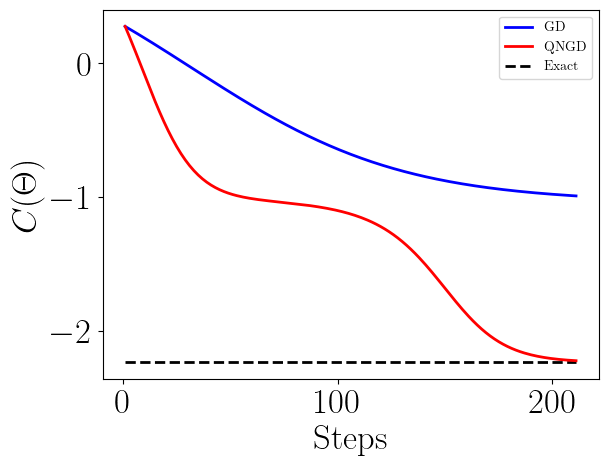

In [218]:
fig,ax = plt.subplots(1,1)
#fig.set_size_inches(4,2.5)
total_steps_gd = np.arange(1,len(gd_cost_history)+1)
total_steps_qngd = np.arange(1,len(qngd_cost_history)+1)

ax.plot(total_steps_gd,gd_cost_history,linewidth=2, label='GD',color='blue')
ax.plot(total_steps_qngd,qngd_cost_history,linewidth=2, label='QNGD',color='red')
ax.plot(total_steps_gd,gs_energy*np.ones(len(total_steps_gd)),linestyle='dashed',linewidth=2,color='black',zorder=-1, label='Exact')

ax.set_xlabel(r'Steps',fontsize=25)
ax.set_ylabel(r"$C(\Theta)$",fontsize=25)
ax.tick_params(axis='both', labelsize=25)

ax.legend()

plt.show()

We can directly watch this in parameter space. To get this, we need to compute the cost function at every (grid) point:

In [219]:
M=50
theta_vec = np.array(np.linspace(0,2*np.pi,M),requires_grad=True)
gamma_vec = np.array(np.linspace(0,2*np.pi,M),requires_grad=True)

y = np.zeros((M,M),requires_grad =True)
for i in range(M):
    for j in range(M):
        x = np.array([theta_vec[i],gamma_vec[j]],requires_grad=True)
        y[i,j] = cost_function(x)

In [220]:
thetasqn_resize = np.array(qngd_param_history)*M/(2*np.pi)
thetas_resize = np.array(gd_param_history)*M/(2*np.pi)

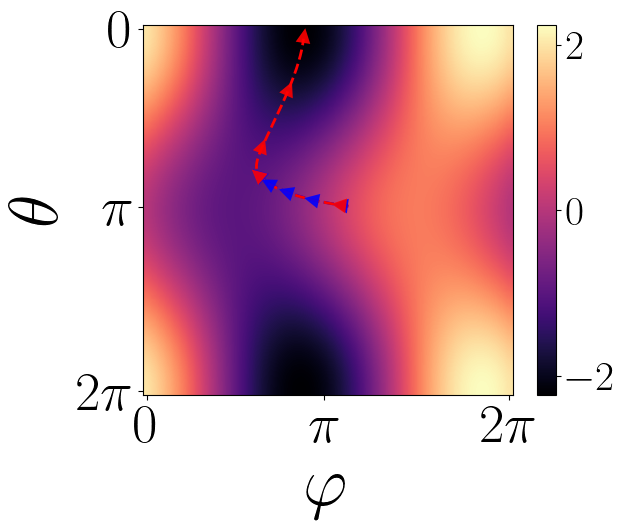

In [222]:
fig,ax = plt.subplots(1,1)

img = ax.imshow(np.transpose(y),interpolation='gaussian',cmap=plt.get_cmap('magma'))
ax.plot(thetas_resize[:,0],thetas_resize[:,1],linewidth=2,linestyle='dashed',color='blue')
ax.plot(thetasqn_resize[:,0],thetasqn_resize[:,1],linewidth=2,linestyle='dashed',color='red')


X = thetas_resize
for i in range(0,len(thetas_resize),50):
  ax.arrow(X[i][0], X[i][1], X[i+1][0] - X[i][0], X[i+1][1] - X[i][1],shape='full',head_starts_at_zero=False,
             head_width=2, head_length=2, lw=0, fc='blue', ec='black',zorder=100,linewidth=1.0,alpha=0.9)

X = thetasqn_resize
for i in range(0,len(thetasqn_resize),50):
  ax.arrow(X[i][0], X[i][1], X[i+1][0] - X[i][0], X[i+1][1] - X[i][1],shape='full',head_starts_at_zero=False,
             head_width=2, head_length=2, lw=0, fc='red', ec='black',zorder=100,linewidth=1.0,alpha=0.9)

x_label_list = ['0',r'$\pi$',r'$2\pi$']

ax.set_xticks([0.,24,49])

ax.set_xticklabels(x_label_list)

y_label_list = ['0',r'$\pi$',r'$2\pi$']

ax.set_yticks([0.,24,49])

ax.set_yticklabels(y_label_list)

ax.set_ylabel(r"$\theta$",fontsize=50)
ax.set_xlabel(r"$\varphi$",fontsize=50)
ax.tick_params(axis='both', labelsize=40)
#ax.set_title(r"$F\left(\rho,\rho_\mathrm{eff}\right)=\left(\mathrm{Tr}\sqrt{\sqrt{\rho}\rho_\mathrm{eff}\sqrt{\rho}}\right)^2$",fontsize=15)
#ttl = ax.title

#ttl.set_position([.52, 1.1])


cbar=fig.colorbar(img)
#cbar.ax.set_yticklabels(['0','1/2','1']
cbar.ax.tick_params(labelsize=30)
plt.show()